In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Directly download the dataset from kaggle using api

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"yagnas","key":"ca1fa93a7c50ce0493adf2e9cd1e4899"}'}

In [ ]:
! pip install -q kaggle

In [ ]:
!ls

 drive	   flowers-recognition.zip  'kaggle (2).json'  'kaggle (4).json'   sample_data
 flowers  'kaggle (1).json'	    'kaggle (3).json'   kaggle.json


In [ ]:
!rm -r*

rm: invalid option -- '*'
Try 'rm --help' for more information.


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Whatever dataset u want to requires just copy api of particular dataset

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls -lrth

total 225M
-rw-r--r-- 1 root root 225M Jul 16  2021  flowers-recognition.zip
drwxr-xr-x 1 root root 4.0K Feb  9 14:20  sample_data
drwx------ 5 root root 4.0K Feb 12 17:31  drive
-rw-r--r-- 1 root root   62 Feb 12 17:32  kaggle.json
drwxr-xr-x 7 root root 4.0K Feb 12 17:32  flowers
-rw-r--r-- 1 root root   62 Feb 12 17:34 'kaggle (1).json'
-rw-r--r-- 1 root root   62 Feb 12 17:58 'kaggle (2).json'
-rw-r--r-- 1 root root   62 Feb 12 18:08 'kaggle (3).json'
-rw-r--r-- 1 root root   62 Feb 12 18:13 'kaggle (4).json'


!unzipping the flower dataset

In [ ]:
!unzip flowers-recognition.zip

Archive:  flowers-recognition.zip
replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls -lrth flowers/
#!mv flowers/flowers/ content/
#!ls -lrth content/flowers

total 260K
drwxr-xr-x 2 root root 36K Feb 12 17:32 daisy
drwxr-xr-x 2 root root 64K Feb 12 17:32 dandelion
drwxr-xr-x 2 root root 44K Feb 12 17:32 rose
drwxr-xr-x 2 root root 36K Feb 12 17:32 sunflower
drwxr-xr-x 2 root root 60K Feb 12 17:32 tulip


The pictures are divided into five classes: daisy, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
import os
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

Declaring local varibles to be used in this process

In [ ]:
imgs_path='flowers/'
img_size=224
batch_size=32

**Data preprocessing**

In [ ]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data = get_data(imgs_path)

<ipython-input-15-f937c98719e0>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<Axes: ylabel='count'>

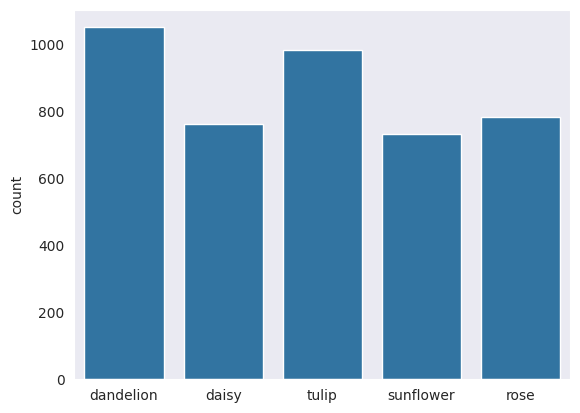

In [ ]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(x=l)

The dataset seems balanced as for each training label , enough training examples exist



Finding corrupted and unusual images


In [ ]:
from PIL import Image
import os

def count_images_issues(folder_path):
    corrupted_count = 0
    extreme_pixel_count = 0
    unusual_dimensions_count = 0

    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)

        # Skip directories
        if os.path.isdir(image_path):
            continue

        try:
            # Open the image
            img = Image.open(image_path)

            # Check for corrupted images
            img.verify()

            # Check for extreme pixel values
            pixel_values = list(img.getdata())
            if any(min(pixel) < 0 or max(pixel) > 255 for pixel in pixel_values):
                extreme_pixel_count += 1

            # Check for unusual dimensions
            width, height = img.size
            if width != expected_width or height != expected_height:
                unusual_dimensions_count += 1

        except (IOError, SyntaxError) as e:
            corrupted_count += 1
            print(f"Corrupted image: {filename}, Error: {e}")

    return corrupted_count, extreme_pixel_count, unusual_dimensions_count

# Example usage
folder_path = 'flowers'  # Replace with the actual path to your image folder
expected_width, expected_height = 224, 224  # Set your expected dimensions

corrupted, extreme_pixel, unusual_dimensions = count_images_issues(folder_path)

print(f"Number of corrupted images: {corrupted}")
print(f"Number of images with extreme pixel values: {extreme_pixel}")
print(f"Number of images with unusual dimensions: {unusual_dimensions}")

Number of corrupted images: 0
Number of images with extreme pixel values: 0
Number of images with unusual dimensions: 0


Randomly Previewing first 10 images



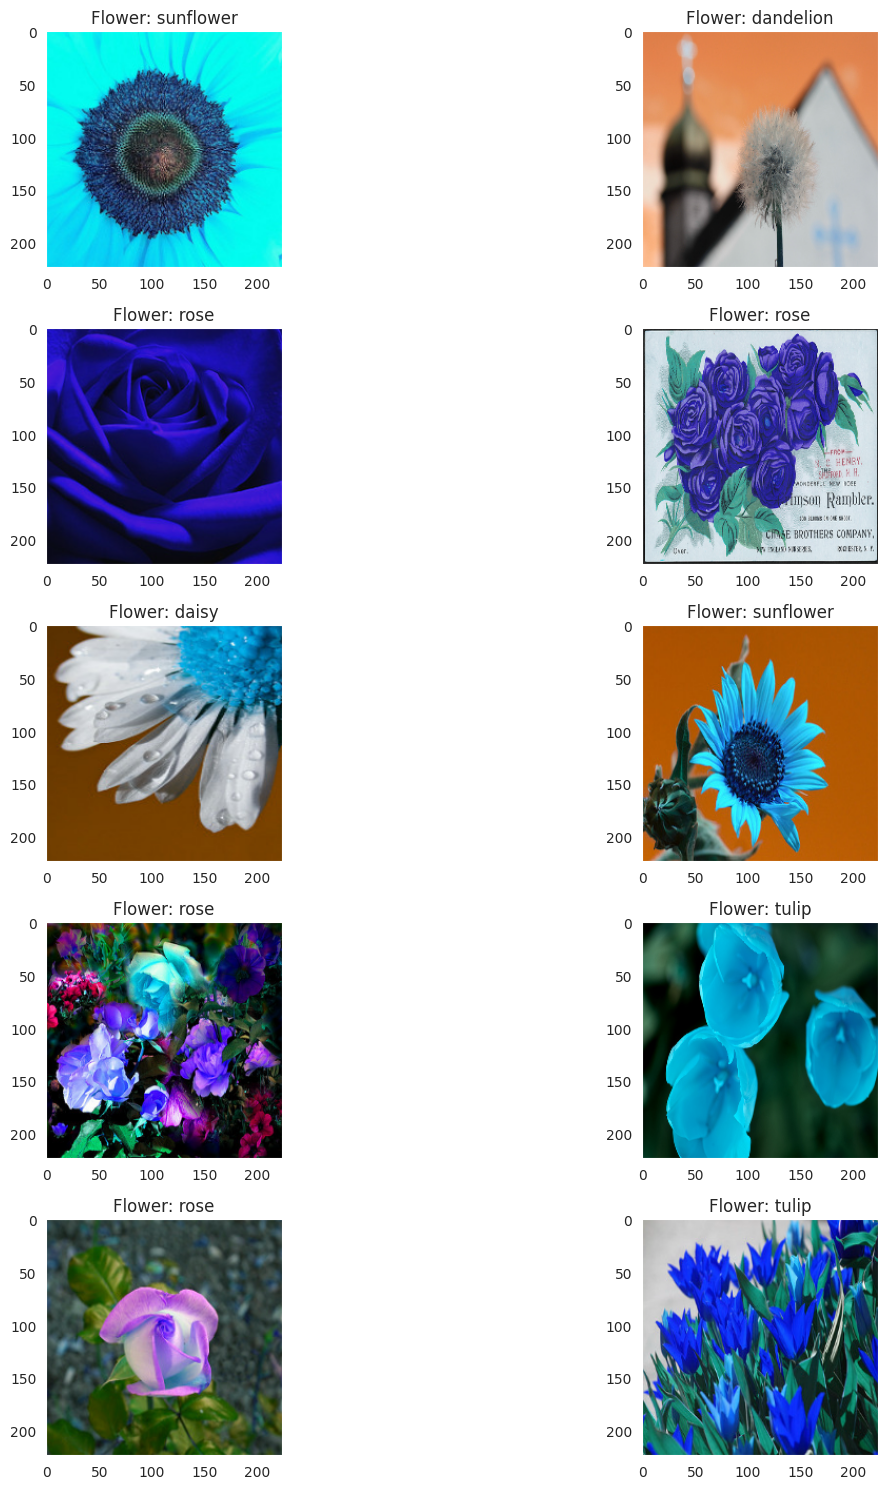

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])

plt.tight_layout()

In [ ]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [ ]:
# Normalize the data
x = np.array(x) / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)

In [ ]:
del x,y,data#----->must run command otherwise

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Model
from tensorflow.keras.layers import MaxPool2D,Dense,Flatten,Dropout
from tensorflow import keras
from tensorflow.keras.models import Sequential


pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

model=Sequential()
model.add(pre_trained_model)
model.add(MaxPool2D((2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(5,activation='softmax'))
'''model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])'''

model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 5)                 23045     
                                                                 
Total params: 20047429 (76.47 MB)
Trainable params: 4742661 (18.09 MB)
Non-trainable params: 15304768 (58.38 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
learning_rate=ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.0001)
cb_early_stop=EarlyStopping(monitor = 'val_loss', patience = 3)
callbacks_list=[learning_rate,cb_early_stop]

In [ ]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64,callbacks=[callbacks_list])

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
'''predictions = model.predict_classes(x_test)
predictions[:5]
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
y_predict = np.argmax(model.predict(x_test), axis=-1)'''
predictions=np.argmax(model.predict(x_test), axis=-1)
predictions[:5]

In [ ]:
plt.imshow(x_test[4])

In [ ]:
y_test[0:5]

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)
y_test_inv[0:5]

In [ ]:


from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_inv, predictions, target_names = labels))

In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = labels , columns = labels)

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

correctly classified images

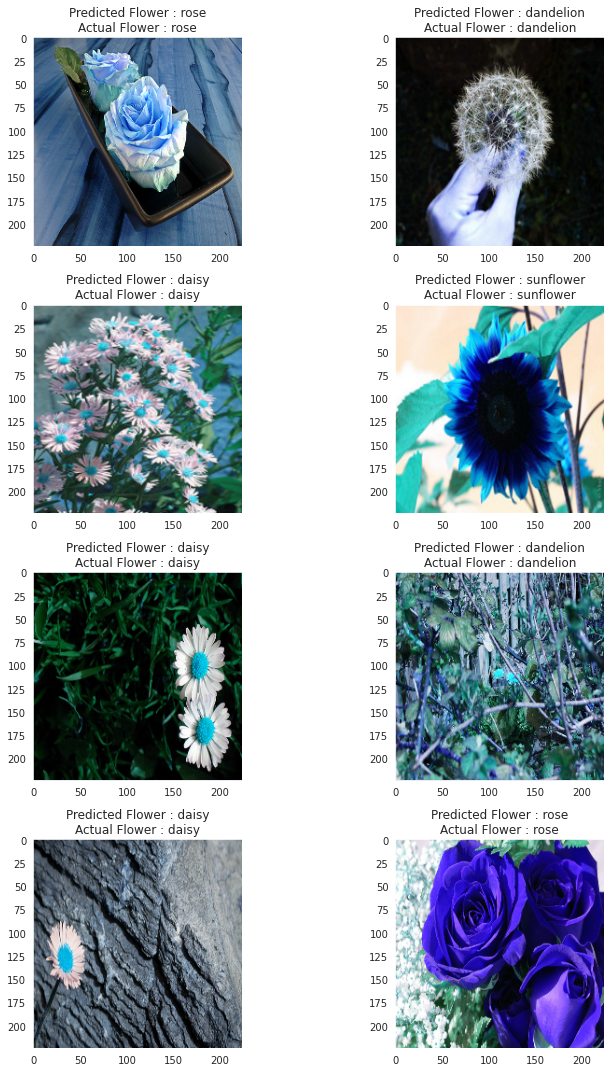

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

mis-classified images

In [ ]:
labels

['dandelion', 'daisy', 'tulip', 'sunflower', 'rose']

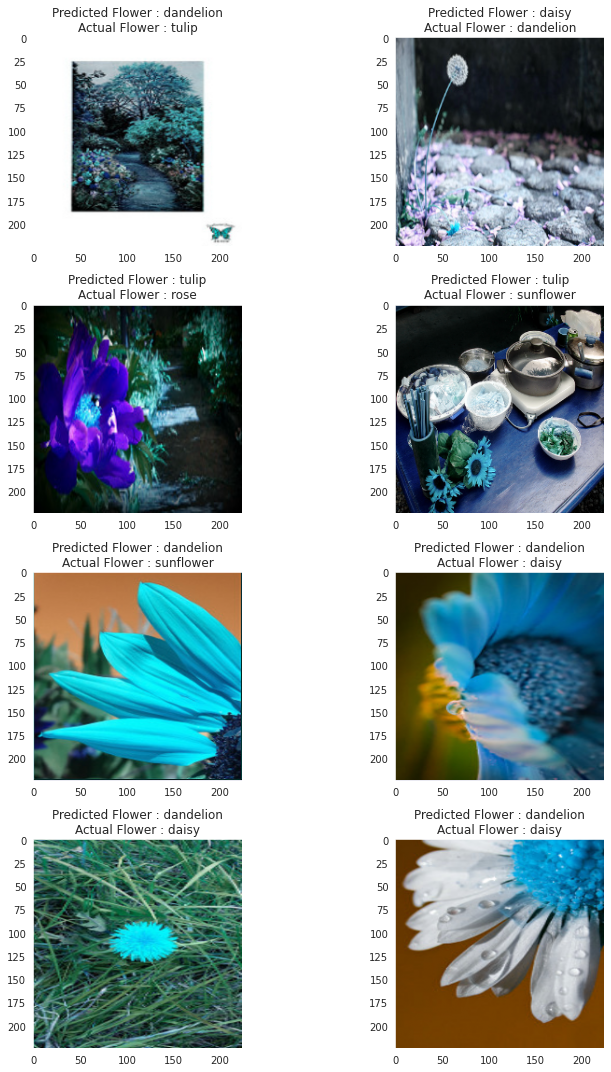

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1

In [ ]:
model.save_weights('/content/flower_vgg19.h5')

Text(0.5, 1.0, 'val accuracy')

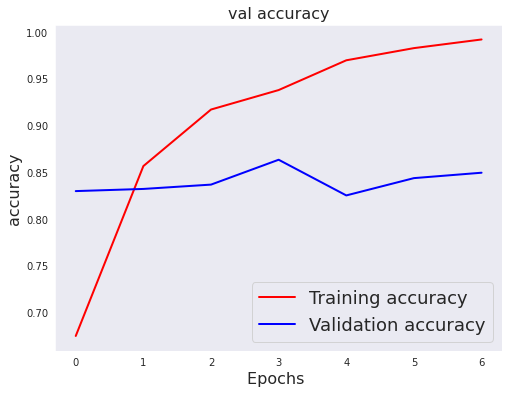

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.title('val accuracy',fontsize=16)

Now testing on external images

In [ ]:
from google.colab import files
files.upload()

Saving tulipflower.jpg to tulipflower.jpg


{'tulipflower.jpg': b'\xff\xd8\xff\xdb\x00C\x00\x04\x03\x03\x04\x03\x03\x04\x04\x04\x04\x05\x05\x04\x05\x07\x0b\x07\x07\x06\x06\x07\x0e\n\n\x08\x0b\x10\x0e\x11\x11\x10\x0e\x10\x0f\x12\x14\x1a\x16\x12\x13\x18\x13\x0f\x10\x16\x1f\x17\x18\x1b\x1b\x1d\x1d\x1d\x11\x16 "\x1f\x1c"\x1a\x1c\x1d\x1c\xff\xdb\x00C\x01\x05\x05\x05\x07\x06\x07\r\x07\x07\r\x1c\x12\x10\x12\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\x1c\xff\xc2\x00\x11\x08\x01\xf4\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x03\x06\x00\x02\x07\x01\x08\xff\xc4\x00\x1b\x01\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xba\tR\'\x8e\x9bK\x9aCs\xb6j"\xd5\xd6\xbe\xc6\xae\xc0\xd6\x137\xaa\xdal\xf5

(1, 224, 224, 3)

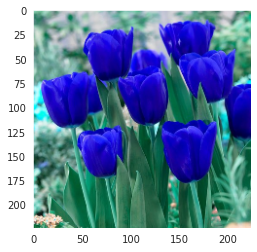

In [ ]:
image_name='tulipflower.jpg'   # enter image to test
x1=[]
img_1 = cv2.imread(image_name, cv2.IMREAD_COLOR)  #
resized_arr_1 = cv2.resize(img_1, (img_size, img_size)) # Reshaping images to preferred size
plt.imshow(resized_arr_1)
x1.append([resized_arr_1])
x1=np.array(x1)
# plt.imshow(x)
# Normalize the data
x1 = np.array(x1) / 255
x1 = x1.reshape(-1, img_size, img_size, 3)
x1.shape

**getting predictions**

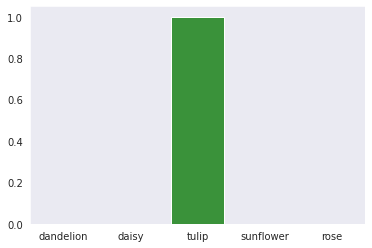

In [ ]:
pred=np.argmax(model.predict(x1), axis=-1) # for predicting class
# print(pred)
prob=model.predict(x1)  # predicting probability
# labels_pred=np.argmax(pred,axis=0)
# labels=get_labels(labels_pred)
flowers = ["dandelion","daisy","tulip","sunflower","rose"]
pred_results=pd.DataFrame(data=prob,columns=flowers)
# print(pred_results.head())
import seaborn as sns
# sns.set_theme(style="darkgrid")
ax=sns.barplot(data=pred_results)
plt.show()
# pred_results.head()